In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

print(f"NumPy: {np.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

NumPy: 1.26.4
scikit-learn: 1.7.2


**Importacion de datos procesados**

Importamos los datos procesados en el analisis EDA

In [2]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


**Creación de funciones generales**

Crearemos funciones generales que seran usadas en cada variante que haremos con las variables predictoras, esto con el fin de evitar escribir codigo en cada variante

In [3]:
def crear_modelo_regresion(df):

    variable_dependiente = 'pib'
    X = df.drop(columns=[variable_dependiente])
    y = df[variable_dependiente]

    # Dividir en conjunto de entrenamiento (80%) y prueba (20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

    # Entrenar modelo
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    return modelo, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred

In [4]:
def evaluar_modelo(modelo, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred):

    print("="*60)
    print("EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE")
    print("="*60)

    # Coeficientes del modelo
    variables = X_train.columns
    print("\n1. COEFICIENTES DEL MODELO:")
    print(f"Intercepto: {modelo.intercept_:.4f}")
    for i, var in enumerate(variables):
        print(f"{var}: {modelo.coef_[i]:.4f}")

    # --- MÉTRICAS ENTRENAMIENTO ---
    print("\n2. MÉTRICAS DEL MODELO (Entrenamiento):")
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    n_train, p = len(y_train), len(variables)
    r2_adj_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)

    print(f"R² Score (train): {r2_train:.4f}")
    print(f"RMSE (train): {rmse_train:.4f}")
    print(f"MAE (train): {mae_train:.4f}")
    print(f"R² ajustado (train): {r2_adj_train:.4f}")

    # --- MÉTRICAS PRUEBA ---
    print("\n3. MÉTRICAS DEL MODELO (Prueba):")
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)
    n_test = len(y_test)
    r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)

    print(f"R² Score (test): {r2_test:.4f}")
    print(f"RMSE (test): {rmse_test:.4f}")
    print(f"MAE (test): {mae_test:.4f}")
    print(f"R² ajustado (test): {r2_adj_test:.4f}")

    return {
        'train': {
            'r2': r2_train,
            'rmse': rmse_train,
            'mae': mae_train,
            'r2_adjusted': r2_adj_train
        },
        'test': {
            'r2': r2_test,
            'rmse': rmse_test,
            'mae': mae_test,
            'r2_adjusted': r2_adj_test
        }
    }

In [5]:
def graficar_resultados(y, y_pred):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico 1: Valores reales vs predicciones
    axes[0].scatter(y, y_pred, alpha=0.7, color='blue')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valores Reales')
    axes[0].set_ylabel('Predicciones')
    axes[0].set_title('Valores Reales vs Predicciones')
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Residuos
    residuos = y - y_pred
    axes[1].scatter(y_pred, residuos, alpha=0.7, color='blue')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Predicciones')
    axes[1].set_ylabel('Residuos')
    axes[1].set_title('Análisis de Residuos')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [6]:
def analisis_residuos(y, y_pred):

    residuos = y - y_pred
    
    print("\n4. ANÁLISIS DE RESIDUOS:")
    
    # Test de normalidad de residuos (Shapiro-Wilk)
    if len(residuos) <= 5000:  # Shapiro-Wilk tiene límite de muestra
        stat, p_value = stats.shapiro(residuos)
        print(f"Test de Normalidad (Shapiro-Wilk): p-valor = {p_value:.4f}")
        if p_value > 0.05:
            print("Los residuos siguen una distribución normal (p > 0.05)")
        else:
            print("Los residuos NO siguen una distribución normal (p ≤ 0.05)")
    
    # Estadísticas básicas de residuos
    print(f"Media de residuos: {np.mean(residuos):.6f}")
    print(f"Desviación estándar de residuos: {np.std(residuos):.4f}")
    
    # Durbin-Watson (aproximado para autocorrelación)
    dw = np.sum(np.diff(residuos)**2) / np.sum(residuos**2)
    print(f"Estadístico Durbin-Watson: {dw:.4f}")
    if 1.5 < dw < 2.5:
        print("No hay evidencia fuerte de autocorrelación")
    else:
        print("Posible autocorrelación en los residuos")

In [7]:
def diagnosticos_modelo(X,y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print("AIC:", model.aic)
    print("BIC:", model.bic)
    print("R2 ajustado:", model.rsquared_adj)

In [8]:
def hacer_prediccion(modelo, nuevos_datos):
    prediccion = modelo.predict(nuevos_datos)
    return prediccion

In [9]:
def crear_y_evaluar_modelo_completo(df):
    # Crear y entrenar el modelo con 80% de entrenamiento y 20% de prueba
    modelo, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred = crear_modelo_regresion(df)
    
    # Evaluar el modelo en ambos conjuntos
    metricas = evaluar_modelo(modelo, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)
    
    # Análisis de residuos del conjunto de prueba
    analisis_residuos(y_test, y_test_pred)
    
    print("\n=== DIAGNÓSTICOS DEL MODELO ===")
    # Diagnósticos y gráficos con el conjunto de entrenamiento
    diagnosticos_modelo(X_train, y_train)
    
    # Gráfica de valores reales vs. predichos del conjunto de prueba
    graficar_resultados(y_test, y_test_pred)
    
    return modelo, metricas

**Generación de modelos**

En esta sección generaremos los modelos, cada uno variando en sus variables predictoras para ver el comportamiento y poder elegir el mejor modelo

**Modelo: M1**

En este modelo usaremos como variables predictoras: 
- exportaciones
- importaciones 
- precio del petroleo 
- consumo final 
- inversion total 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 52
Tamaño del conjunto de prueba: 13
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0065
exportaciones: 0.2049
importaciones: 0.1110
precio_petroleo: -0.0076
consumo_final: 0.6440
inversion_total: 0.1221
tasa_inflacion: 0.1894

2. MÉTRICAS DEL MODELO (Entrenamiento):
R² Score (train): 0.8779
RMSE (train): 0.3221
MAE (train): 0.2614
R² ajustado (train): 0.8617

3. MÉTRICAS DEL MODELO (Prueba):
R² Score (test): 0.9706
RMSE (test): 0.1978
MAE (test): 0.1517
R² ajustado (test): 0.9413

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.4020
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: -0.032629
Desviación estándar de residuos: 0.1951
Estadístico Durbin-Watson: 2.6014
Posible autocorrelación en los residuos

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 43.75711679913755
BIC: 57.41582282920754
R2 ajustado: 0.8616536174118348


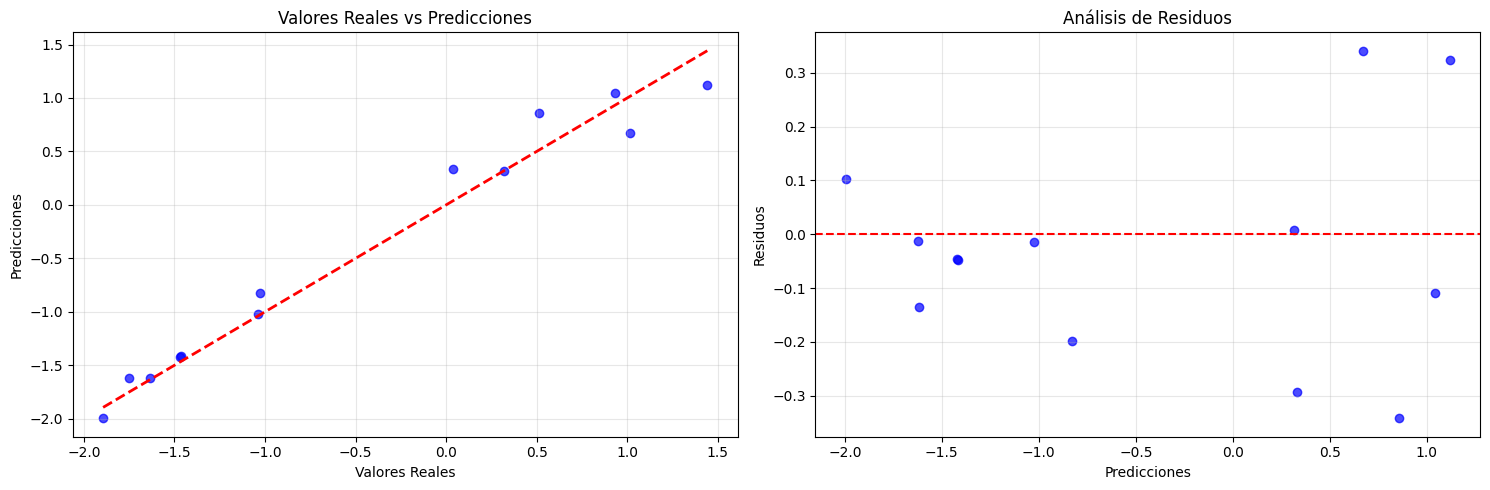

(LinearRegression(),
 {'train': {'r2': 0.8779296624222072,
   'rmse': 0.32212603076092144,
   'mae': 0.26143831469187806,
   'r2_adjusted': 0.8616536174118348},
  'test': {'r2': 0.9706413338468332,
   'rmse': 0.19779944351337073,
   'mae': 0.15173957936367188,
   'r2_adjusted': 0.9412826676936663}})

In [10]:
df1 = df.drop('igae', axis=1)
crear_y_evaluar_modelo_completo(df1)

**Modelo: M2**

En este modelo usaremos como variables predictoras: 
- exportaciones
- precio del petroleo 
- inversion total 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 52
Tamaño del conjunto de prueba: 13
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: -0.0108
exportaciones: 0.1763
precio_petroleo: 0.0614
inversion_total: 0.7559
tasa_inflacion: 0.0261

2. MÉTRICAS DEL MODELO (Entrenamiento):
R² Score (train): 0.7231
RMSE (train): 0.4852
MAE (train): 0.3212
R² ajustado (train): 0.6995

3. MÉTRICAS DEL MODELO (Prueba):
R² Score (test): 0.8891
RMSE (test): 0.3845
MAE (test): 0.2574
R² ajustado (test): 0.8336

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.0063
Los residuos NO siguen una distribución normal (p ≤ 0.05)
Media de residuos: 0.053905
Desviación estándar de residuos: 0.3807
Estadístico Durbin-Watson: 2.0796
No hay evidencia fuerte de autocorrelación

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 82.34752108405766
BIC: 92.1037396769648
R2 ajustado: 0.6995378818244395


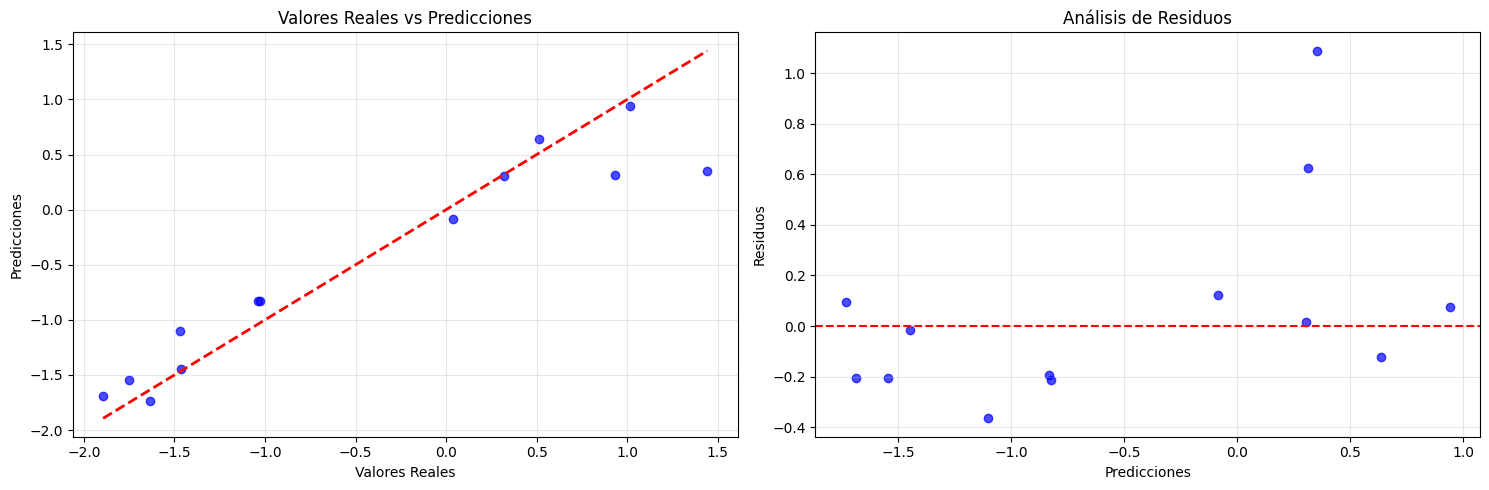

(LinearRegression(),
 {'train': {'r2': 0.7231035381519344,
   'rmse': 0.4851538159618558,
   'mae': 0.32122289467081183,
   'r2_adjusted': 0.6995378818244394},
  'test': {'r2': 0.8890503679187555,
   'rmse': 0.3845208010608823,
   'mae': 0.25736128289432747,
   'r2_adjusted': 0.8335755518781331}})

In [11]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
crear_y_evaluar_modelo_completo(df2)

**Modelo: M3**

En este modelo usaremos como variables predictoras: 
- importaciones 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 52
Tamaño del conjunto de prueba: 13
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0057
importaciones: 0.2783
precio_petroleo: 0.0650
consumo_final: 0.6901
tasa_inflacion: 0.2344

2. MÉTRICAS DEL MODELO (Entrenamiento):
R² Score (train): 0.8477
RMSE (train): 0.3598
MAE (train): 0.2869
R² ajustado (train): 0.8348

3. MÉTRICAS DEL MODELO (Prueba):
R² Score (test): 0.9835
RMSE (test): 0.1481
MAE (test): 0.1360
R² ajustado (test): 0.9753

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.2792
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: -0.028688
Desviación estándar de residuos: 0.1453
Estadístico Durbin-Watson: 1.0212
Posible autocorrelación en los residuos

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 51.24566042833246
BIC: 61.001879021239596
R2 ajustado: 0.83479138998441


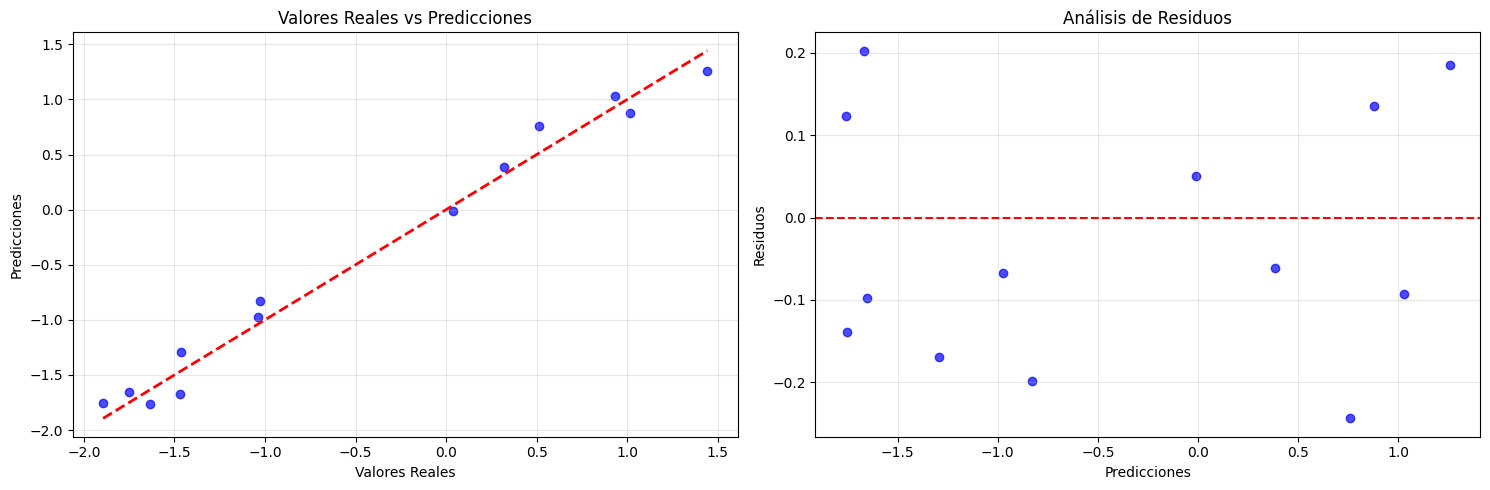

(LinearRegression(),
 {'train': {'r2': 0.8477489280248485,
   'rmse': 0.3597501038756522,
   'mae': 0.2869018706612081,
   'r2_adjusted': 0.83479138998441},
  'test': {'r2': 0.9835413269470524,
   'rmse': 0.14809974620340843,
   'mae': 0.13600161709499514,
   'r2_adjusted': 0.9753119904205787}})

In [12]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df3)

**Modelo: M4**

En este modelo usaremos como variables predictoras: 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 52
Tamaño del conjunto de prueba: 13
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0371
precio_petroleo: 0.1512
consumo_final: 0.7885
tasa_inflacion: 0.2804

2. MÉTRICAS DEL MODELO (Entrenamiento):
R² Score (train): 0.7902
RMSE (train): 0.4223
MAE (train): 0.3301
R² ajustado (train): 0.7771

3. MÉTRICAS DEL MODELO (Prueba):
R² Score (test): 0.9222
RMSE (test): 0.3220
MAE (test): 0.2960
R² ajustado (test): 0.8963

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.0155
Los residuos NO siguen una distribución normal (p ≤ 0.05)
Media de residuos: -0.185367
Desviación estándar de residuos: 0.2632
Estadístico Durbin-Watson: 1.3453
Posible autocorrelación en los residuos

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 65.90641459758635
BIC: 73.71138947191206
R2 ajustado: 0.7771375671823455


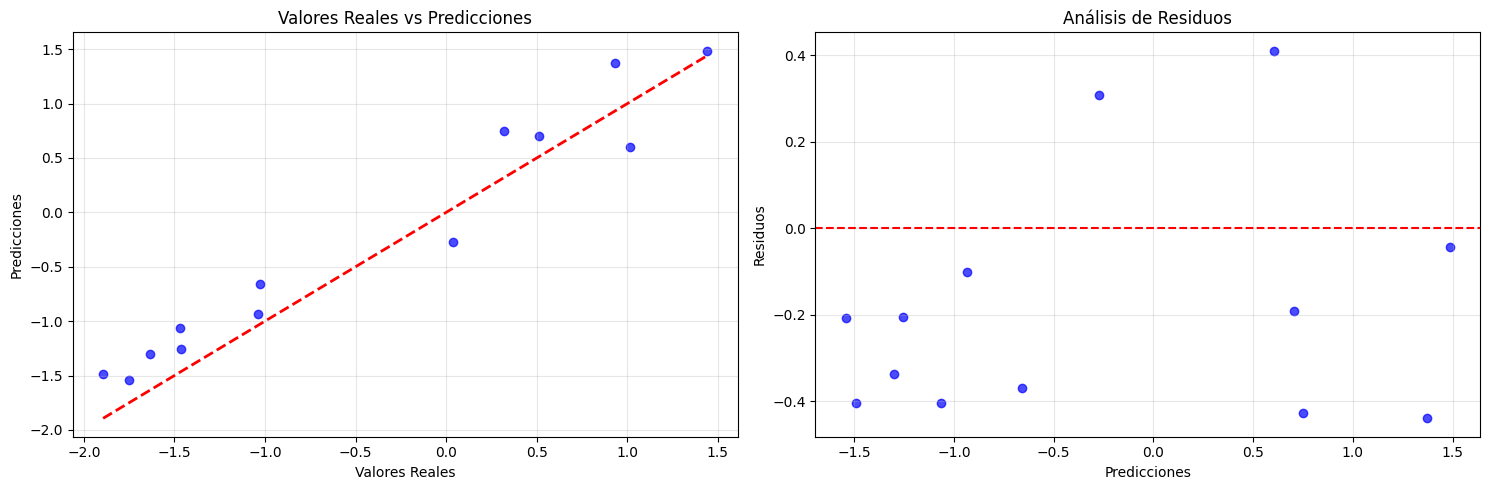

(LinearRegression(),
 {'train': {'r2': 0.7902471220539723,
   'rmse': 0.4222549142345919,
   'mae': 0.330081384064855,
   'r2_adjusted': 0.7771375671823456},
  'test': {'r2': 0.9222185784872005,
   'rmse': 0.3219547546422831,
   'mae': 0.29599435527496243,
   'r2_adjusted': 0.896291437982934}})

In [13]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df4)

**Modelo: M5**

En este modelo usaremos como variables predictoras: 
- importaciones 
- precio del petroleo 
- tasa de inflacion

Tamaño del conjunto de entrenamiento: 52
Tamaño del conjunto de prueba: 13
EVALUACIÓN DEL MODELO DE REGRESIÓN MÚLTIPLE

1. COEFICIENTES DEL MODELO:
Intercepto: 0.0169
importaciones: 0.5378
precio_petroleo: 0.0018
tasa_inflacion: 0.2512

2. MÉTRICAS DEL MODELO (Entrenamiento):
R² Score (train): 0.4719
RMSE (train): 0.6700
MAE (train): 0.4648
R² ajustado (train): 0.4389

3. MÉTRICAS DEL MODELO (Prueba):
R² Score (test): 0.5099
RMSE (test): 0.8082
MAE (test): 0.6851
R² ajustado (test): 0.3465

4. ANÁLISIS DE RESIDUOS:
Test de Normalidad (Shapiro-Wilk): p-valor = 0.3193
Los residuos siguen una distribución normal (p > 0.05)
Media de residuos: -0.084364
Desviación estándar de residuos: 0.8037
Estadístico Durbin-Watson: 1.4280
Posible autocorrelación en los residuos

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 113.92340998678887
BIC: 121.72838486111458
R2 ajustado: 0.4388667243039539


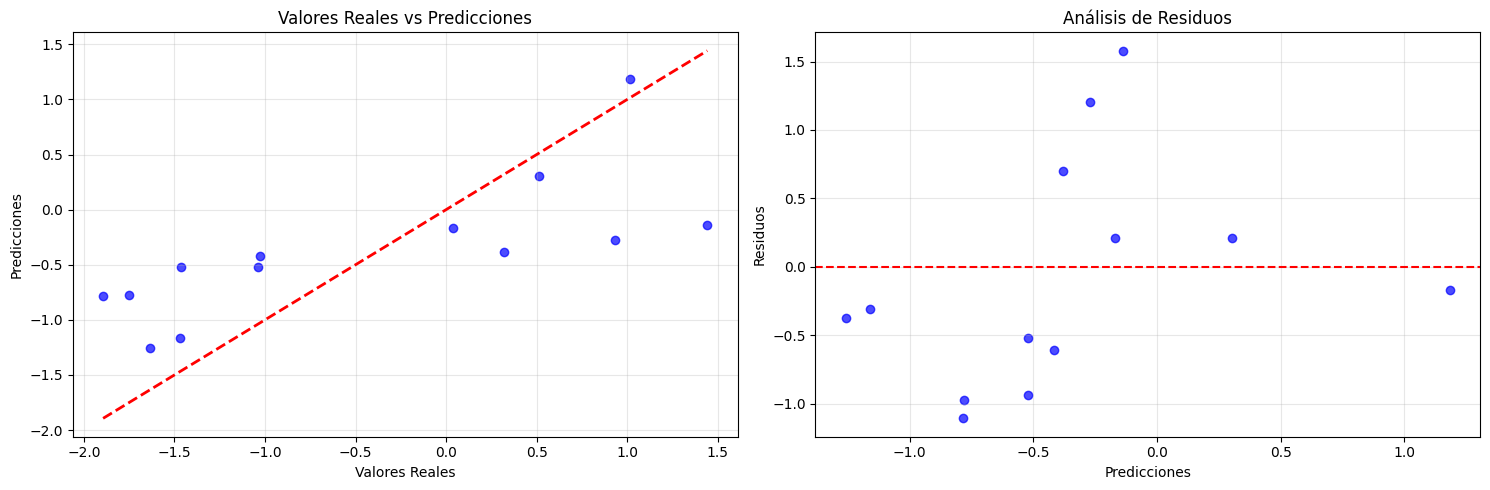

(LinearRegression(),
 {'train': {'r2': 0.4718745640507801,
   'rmse': 0.6700223516991209,
   'mae': 0.46483785527122595,
   'r2_adjusted': 0.4388667243039538},
  'test': {'r2': 0.509901733521644,
   'rmse': 0.8081621161847342,
   'mae': 0.6851172217557817,
   'r2_adjusted': 0.34653564469552534}})

In [14]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
crear_y_evaluar_modelo_completo(df5)

**Conclusión**

En base a los valores obtenidos en cada modelo generado, se puede apreciar y seleccionar al modelo **M3** como el mejor modelo de todos